# CarbonLoop Part 2

In [13]:
import os
from util_functions import *
import yaml
import json
import sys

### 1. Read Output from Timeloop+Accelergy and Save in Yaml Files

In [10]:

# Generate arch dirctory list
arch_type = 'eyeriss_like'
pe_list = [1,4,9,16,25,36,49,64,81,100,121,144,169,196,225,256,289,324,361,400]
arch = []
for pe in pe_list:
    arch.append(arch_type+'_pe_'+str(pe))

for arch_name in arch:
    tl_output_path = "outputs/"+arch_name
    tl_file_name = 'timeloop-mapper.stats.txt'
    output_yaml = os.path.join(tl_output_path, 'timeloop_summary.yaml')
    
    layer_dirs = search_directories(tl_output_path)
    dram_weight_caps = []
    energy = []
    cycles = []
    dram_inout_max = 0
    chip_area_max = 0
    
    for layer_dir in layer_dirs[1:]:
        if 'eyeriss_like' in layer_dir.split('/')[-1]:
            file_path = os.path.join(layer_dir, tl_file_name)
            
            dram_caps = extract_dram_utilized_capacity(file_path)
            if (dram_caps[0]+dram_caps[1]) > dram_inout_max:
                dram_inout_max = dram_caps[0]+dram_caps[1]
            dram_weight_caps.append(dram_caps[2])
            
            chip_area = extract_total_chip_area(file_path)
            if chip_area > chip_area_max:
                chip_area_max = chip_area
                
            energy.append(extract_total_energy(file_path))
            cycles.append(extract_total_cycles(file_path))
    
    total_cap = dram_inout_max + sum(dram_weight_caps)
    total_area = chip_area_max
    total_energy = sum(energy)
    total_cycles = sum(cycles)

    # ### Print Timeloop+Accelergy output ###
    # print()
    # print("DRAM Specifications of %s:"%(arch_name))
    # print("Total DRAM Capacity (Byte) :", total_cap)
    # print("Total Chip Area (um^2)     :", total_area)
    # print("Total Energy (uJ)          :", total_energy)
    # print("Total Cycles               :", total_cycles)

    ### Write to yaml file ###
    save_to_yaml(output_yaml, total_cap, total_area, total_energy, total_cycles)
    # print(f"YAML saved to: {output_yaml}")


### 2. Import data from yaml files

In [12]:
total_cap_list = []
total_area_list = []
total_energy_list = []
total_cycles_list = []
for arch_name in arch:
    yaml_path = 'outputs/'+arch_name+'/timeloop_summary.yaml'
    with open(yaml_path, 'r') as f:
        summary = yaml.safe_load(f)
    total_cap_list.append(summary['dram_utilized_capacity'])
    total_area_list.append(summary['total_chip_area_um2'])
    total_energy_list.append(summary['total_energy_uJ'])
    total_cycles_list.append(summary['total_cycles'])


### 2. Calculate Carbon Footprint using ACT

In [15]:
# Import ACT libraries
if "/home/workspace/ACT-tutorial" not in sys.path:
    sys.path.append("/home/workspace/ACT-tutorial")
if not os.path.exists("/home/workspace/ACT-tutorial"):
    raise FileNotFoundError(f"Provided path does not exist: /home/workspace/ACT-tutorial")
from dram_model import Fab_DRAM
from hdd_model import Fab_HDD
from ssd_model import Fab_SSD
from logic_model  import Fab_Logic

# Assume parameters
# Refernce: https://www.extremetech.com/computing/data-center-ai-gpus-may-have-extremely-short-lifespans
use_ci     = "loc_usa"
Kr         = 0.15   # kg CO2
T          = 1.8    # years
LT         = 3      # years
clock_freq = 200    # MHz

# Initialize components
processor = Fab_Logic(process_node=28, gpa="95", fab_carbon_intensity="loc_taiwan", use_carbon_intensity="loc_usa",debug=False, fab_yield=0.8)
DRAM      = Fab_DRAM(config="lpddr4",fab_yield=0.8)
N         = 2

cf_package_list = []
cf_processor_list = []
cf_DRAM_list = []
cf_embodied_list = []
cf_dis_embodied_list = []
cf_operational_list = []
cf_final_list = []
for total_cap, total_area, total_energy, total_cycles in zip(total_cap_list, total_area_list, total_energy_list, total_cycles_list):
    # Input parameters to ACT
    n_run     = (T *365*24*60*60) / ((1/(clock_freq*1000000))*total_cycles)
    total_area_cm2 = total_area / 100000000
    total_cap_GB = total_cap/1000000000
    total_energy_kWh = total_energy / (3600*10**9)
    processor.set_area(total_area_cm2)
    DRAM.set_capacity(total_cap_GB)
    
    # Calculate Carbon Footprint (kg Co2)
    cf_package_list.append(N * Kr)
    cf_processor_list.append(processor.get_carbon() / 1000.)
    cf_DRAM_list.append(DRAM.get_carbon() / 1000.)
    cf_embodied_list.append(cf_package_list[-1] + cf_processor_list[-1] + cf_DRAM_list[-1])
    cf_dis_embodied_list.append(T/LT*cf_embodied_list[-1])
    cf_operational_list.append(processor.get_use_ci() * n_run * total_energy_kWh / 1000.)
    cf_final_list.append(cf_operational_list[-1] + cf_dis_embodied_list[-1])

### 3. Visualize the Result

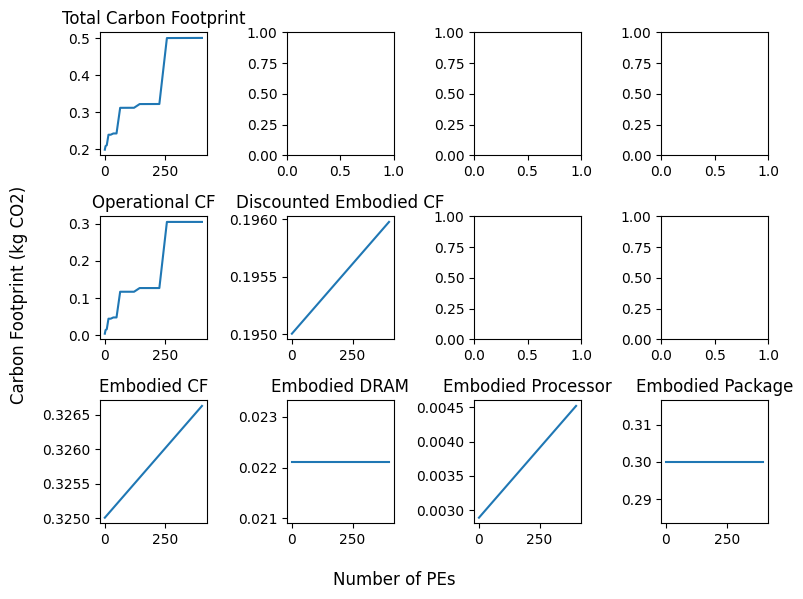

In [17]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 6))

# Plot data on each subplot
axes[0, 0].plot(pe_list, cf_final_list)
axes[1, 0].plot(pe_list, cf_operational_list)
axes[1, 1].plot(pe_list, cf_dis_embodied_list)
axes[2, 0].plot(pe_list, cf_embodied_list)
axes[2, 1].plot(pe_list, cf_DRAM_list)
axes[2, 2].plot(pe_list, cf_processor_list)
axes[2, 3].plot(pe_list, cf_package_list)

# Add titles and labels
axes[0, 0].set_title('Total Carbon Footprint')
axes[1, 0].set_title('Operational CF')
axes[1, 1].set_title('Discounted Embodied CF')
axes[2, 0].set_title('Embodied CF')
axes[2, 1].set_title('Embodied DRAM')
axes[2, 2].set_title('Embodied Processor')
axes[2, 3].set_title('Embodied Package')
fig.supxlabel("Number of PEs")
fig.supylabel("Carbon Footprint (kg CO2)")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()